In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# These libraries allow interaction
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

# Allow viewing plots in jupyter
%matplotlib inline

## Check out the README for usage but quickly

* The requirements are in `requirements.txt` 
  * Install with `pip install -r requirements.txt`
* The dataset is [the two sigman connect rental](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data)
  * Install it with the [kaggle api](https://github.com/Kaggle/kaggle-api) 
  * `kaggle competitions download -c two-sigma-connect-rental-listing-inquiries` at the root of the project
  * `unzip two-sigma-connect-rental-listing-inquiries.zip`
  * `unzip train.json.zip`

In [20]:
df = pd.read_json('./train.json')

In [22]:
df.shape

(49352, 15)

In [27]:
df.head(1) # Quite a a verbose output

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium


In [28]:
df['interest_level'].value_counts()

low       34284
medium    11229
high       3839
Name: interest_level, dtype: int64

In [36]:
df['price'].max(), df['price'].min() # 43 dollars!

(4490000, 43)

We begin by reading in the data, and reading some basic information about it.

We learn that the data: 
 * Has ~49,000 rows with 15 columns
   * 14 features, and the class `interest_level` that we must predict
 * The `interest_level` class has three possible values:
   * `low`, `medium`, and `high`
 * Maximum and minimum prices are 4.9 million dollars and 43 dollars respectively
   * As much as a broke student such as myself would love to believe in the 43 dollar listing, this is probably an error 

Let's visualize those target variables 👀 :

low       0.694683
medium    0.227529
high      0.077788
Name: interest_level, dtype: float64

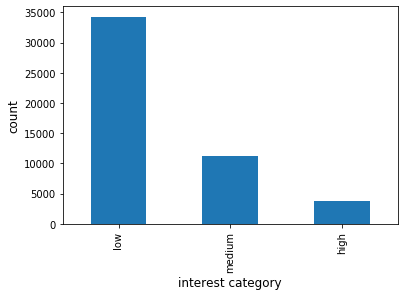

In [215]:
plt.ylabel('count', fontsize=12)
plt.xlabel('interest category', fontsize=12)
df['interest_level'].value_counts().plot(kind="bar");
df['interest_level'].value_counts(normalize=True)

We can see clearly there are many low-interest listings, and it slowly tapers off with very few high interest listings. Proportion percentages are shown on top.

We will now convert the data types in order to parse them correctly (such as dates)

In [56]:
df['created'] = pd.to_datetime(df['created'])

We can now do some analysis on the properties of this dataframe.

For example, we will plot the 

### Hour-wise listing counts: 

**Note** this is an _interactive_ function and will not render on github. Run the notebook locally instead. Use the dropdown to view the different types of plots.

In [178]:
hours = df['created'].groupby(
    df["created"].dt.hour
).count()

@interact
def show_hour_plot(kind=['line', 'bar']):
    plt.ylabel('count', fontsize=12)
    hours.plot(kind=kind);

interactive(children=(Dropdown(description='kind', options=('line', 'bar'), value='line'), Output()), _dom_cla…

In [99]:
hours.nlargest(10)

created
2     10596
3      8318
5      7954
1      5749
4      5021
6      4446
7      1047
14      782
15      753
12      693
Name: created, dtype: int64

As we can see, the top times are ~1am-7am. Perhaps people are updating then because there is less traffic. Or maybe scripts are running which update at that time. Or perhaps the postings are being made by employees outside of the New York timezone. 

Next, we observe the
### 💸 Price 💸

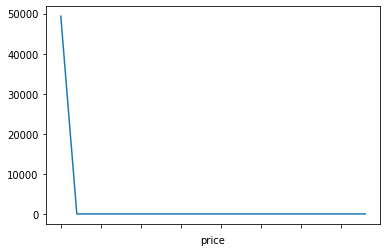

In [125]:
prices = df['price'].groupby(
    pd.cut(df['price'], 20)
).count() 

prices.plot();

We notice that the outliers are intrusive in this case and it would benefit us to remove them. To do this, we will remove the top percentile of some values.

In [179]:
@interact
def show_price_plot(
    kind=['line', 'bar', 'barh', 'area'],
    percentile_limit=(50, 100, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df['price'].values, percentile_limit)
    lost_data = df[df['price']>lim].shape[0]

    adjusted_prices = df[df['price']<lim]['price']
    prices = adjusted_prices.groupby(
        pd.cut(adjusted_prices, bins)
    ).count() 
    
    xticks = [
        prices.index[i].right for i in range(0,len(prices))
    ]
    plt.ylabel('count', fontsize=12)
    prices.plot(
        kind=kind, grid=True
    ).set_xticklabels(xticks);

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'barh', 'area'), value='line'), Flo…

Notice as we drag the percentiles higher (without hitting 100) the graph becomes more and more left-skewed. This shows us almost all the values are in the 2000-6000 dollar range. We find that 20 bins on the bar graph will achieve a good visualization.

Some might find the distribution histogram plot more engaging: 

In [199]:
@interact
def show_price_plot2(
    kind=['line', 'bar', 'barh', 'area'],
    percentile_limit=(50, 100, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df['price'].values, percentile_limit)

    adjusted_prices = df[df['price']<lim]['price']
    
    sns.distplot(
        adjusted_prices.values, 
        bins=bins, 
        kde=True,
    )
    plt.ylabel('share', fontsize=12)
    plt.show()

interactive(children=(Dropdown(description='kind', options=('line', 'bar', 'barh', 'area'), value='line'), Flo…

# Longitude and Lattitude

We will give these columns a similar treatment, allowing the choice between types of graph. Use the dropdowns for your options. We have provided the graphs as well for after for the pdf version of this report.

In [200]:
@interact
def show_long_plot1(
    axis=['longitude','latitude'],
    gtype=['sns','classic'],
    kind=['line', 'bar', 'barh', 'area'],
    upper_limit=(70, 100, 0.5),
    lower_limit=(0, 10, 0.5),
    bins=(10,50,1),
):
    lim = np.percentile(df[axis].values, upper_limit)
    low_lim = np.percentile(df[axis].values, lower_limit)
    
    adjusted = df[df[axis]<lim]
    adjusted = adjusted[adjusted[axis] > low_lim][axis]
    
    if(gtype == "sns"):
        sns.distplot(
            adjusted.values, 
            bins=bins, 
            kde=True,
        )
        plt.ylabel('count', fontsize=12)
        plt.show();
        
    elif(gtype == "classic"):
        prices = adjusted.groupby(
            pd.cut(adjusted, bins)
        ).count() 

        xticks = [
            prices.index[i].right for i in range(0,len(prices))
        ]
        plt.ylabel('share', fontsize=12)
        prices.plot(
            kind=kind, grid=True
        ).set_xticklabels(xticks);
        


interactive(children=(Dropdown(description='axis', options=('longitude', 'latitude'), value='longitude'), Drop…

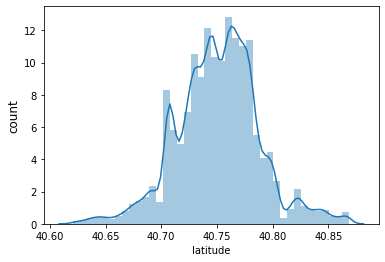

In [209]:
plot = 'latitude'
plt.xlabel(plot)
show_long_plot1(plot,'sns','bar',99.5,0.5,40)

Notice that the values are mostly in the 40-41 range

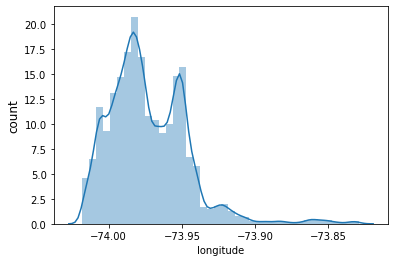

In [210]:
plot = 'longitude'
plt.xlabel(plot)
show_long_plot1(plot,'sns','bar',99.5,0.5,40)

The values are in the -73 to -74 range.

After [some searching](https://www.latlong.net/place/new-york-city-ny-usa-1848.html) we realize these values belong to New York City.

This concludes our data exploration phase, though we did look at other things in the dataset such bedroom distribution and other numerical attributes.